In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 로드 및 전처리

In [37]:
house_df = pd.read_csv('drive/MyDrive/data/level2/train.csv', index_col=0)
house_df['contract_datetime'] = house_df['contract_year_month'].astype(str) + house_df['contract_day'].astype(str)
house_df['contract_datetime'] = pd.to_datetime(house_df['contract_datetime'], format='%Y%m%d')
house_df = house_df.drop(columns=['contract_year_month', 'contract_day'])
house_df.sort_values(by=['latitude', 'longitude'], inplace=True)
house_df.drop_duplicates(inplace=True)

In [38]:
# 위도, 경도를 기준으로 아파트마다 고유한 id를 생성합니다.
loc = house_df[['latitude', 'longitude']].drop_duplicates().values.tolist()
loc_to_id = {tuple(loc): id for id, loc in enumerate(loc)}
loc_tuples = (house_df['latitude'].values, house_df['longitude'].values)
house_df['loc_id'] = [loc_to_id[tuple(loc)] for loc in zip(*loc_tuples)]

# 위도, 경도 및 area_m2를 기준으로 단지마다 고유한 id를 생성합니다.
loc_area = house_df[['latitude', 'longitude', 'area_m2']].drop_duplicates().values.tolist()
loc_area_to_id = {tuple(loc_area): id for id, loc_area in enumerate(loc_area)}
loc_area_tuples = (house_df['latitude'].values, house_df['longitude'].values, house_df['area_m2'].values)
house_df['loc_area_id'] = [loc_area_to_id[tuple(loc_area)] for loc_area in zip(*loc_area_tuples)]

In [68]:
# 단지마다 전세가 그래프를 생성합니다.
house_df.sort_values(by=['loc_area_id', 'contract_datetime'], inplace=True)
grouped_house_df = house_df.groupby('loc_area_id')

full_date_range = pd.date_range(start='2019-01-01', end='2023-01-01', freq='1D')
area_id_to_deposit_series = {
    loc_area_id: deposit_series.set_index('contract_datetime')['deposit']
                           .resample('1d').mean()
                           .reindex(full_date_range)
                           .interpolate(method='linear', limit_area='inside')
                            .rolling(window=90, min_periods=1).mean()
    for loc_area_id, deposit_series in grouped_house_df
}

## Q. 아파트 전세가의 시간에 따른 추이는 어떨까?

<Axes: >

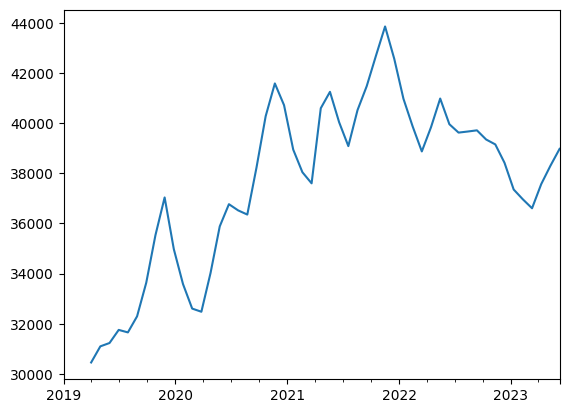

In [40]:
start_datetime = pd.Timestamp('2019-01-01')
end_datetime = pd.Timestamp('2023-06-01')
cur_datetime = start_datetime
delta = pd.Timedelta(days=30)

deposit_time_series = []
while cur_datetime < end_datetime + delta:
    next_datetime = cur_datetime + delta

    # 현재 간격에 존재하는 거래만 선별합니다.
    cur_house_df = house_df[((house_df['contract_datetime'] >= cur_datetime) &
                            (house_df['contract_datetime'] < next_datetime))]
    cur_deposit_mean = cur_house_df['deposit'].mean()
    deposit_time_series.append(cur_deposit_mean)
    cur_datetime = next_datetime

deposit_time_series = pd.Series(
    deposit_time_series,
    index=pd.date_range(start_datetime, end_datetime + delta, freq='30D')
)
deposit_time_series.plot()


## Q: 아파트 내 다른 집이 오르면, area_m2가 달라도 같이 오를까?

In [71]:
id_to_area_ids = {}
for loc_id, group in house_df.groupby('loc_id'):
    id_to_area_ids[loc_id] = group['loc_area_id'].unique()

n_correct_plus = 0
n_correct_minus = 0
n_wrong = 0
for loc_id, area_ids in id_to_area_ids.items():

    # 20년부터 22년까지, 반년 간격으로 측정합니다.
    start_datetime = pd.Timestamp('2020-01-01')
    end_datetime = pd.Timestamp('2022-01-01')
    cur_datetime = start_datetime
    delta = pd.Timedelta(days=180)

    while cur_datetime < end_datetime + delta:
        next_datetime = cur_datetime + delta

        # 같은 아파트 내 집들의 변화를 계산합니다.
        deposit_diffs = []
        for area_id in area_ids:
            deposit_series = area_id_to_deposit_series[area_id]
            cur_deposit = deposit_series.loc[cur_datetime]
            next_deposit = deposit_series.loc[next_datetime]
            deposit_diff = next_deposit - cur_deposit
            if deposit_diff == 0 or np.isnan(deposit_diff):
                continue
            deposit_diffs.append(deposit_diff)

        # 두 집의 변화 추세가 같은지 다른지를 셉니다.
        if len(deposit_diffs) >= 2:
            for diff1, diff2 in itertools.combinations(deposit_diffs, 2):
                if np.sign(diff1) == np.sign(diff2) == 1:
                    n_correct_plus += 1
                elif np.sign(diff1) == np.sign(diff2) == -1:
                    n_correct_minus += 1
                else:
                    n_wrong += 1
        cur_datetime = next_datetime

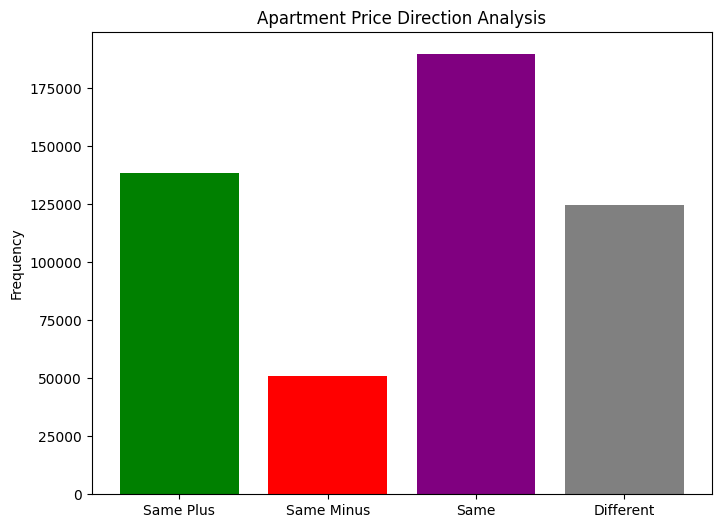

일치율: 0.6034101030665479


In [72]:
import matplotlib.pyplot as plt

# 데이터 준비
categories = ['Same Plus', 'Same Minus', 'Same', 'Different']
values = [n_correct_plus, n_correct_minus, n_correct_plus + n_correct_minus, n_wrong]

# 막대 그래프 생성
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['green', 'red', 'purple', 'grey'])
plt.ylabel('Frequency')
plt.title('Apartment Price Direction Analysis')
plt.show()

print(f'일치율: {(n_correct_plus + n_correct_minus) / (n_wrong + n_correct_plus + n_correct_minus)}')

## Q: 주변(반경 1km) 내 아파트가 오르면 해당 아파트도 오를까?

In [73]:
unique_house_df = house_df.drop_duplicates(subset='loc_id', keep='first')
unique_house_df = unique_house_df.drop(columns=['contract_datetime', 'deposit'])
unique_house_df = unique_house_df.sort_values(by='loc_id')

from scipy.spatial import KDTree
tree = KDTree(unique_house_df[['latitude', 'longitude']])
half_km_results = tree.query_ball_point(unique_house_df[['latitude', 'longitude']].values, r=0.005)

# 아파트 id를 반경 1km 주변 아파트 id로 매핑시키는 dict를 생성합니다.
id_to_half_km_ids = {}
for i, result in enumerate(half_km_results):
    id = unique_house_df.iloc[i]['loc_id']
    half_km_ids = [unique_house_df.iloc[j]['loc_id'] for j in result]
    id_to_half_km_ids[id] = half_km_ids

In [74]:
id_to_area_ids = {}
for loc_id, group in house_df.groupby('loc_id'):
    id_to_area_ids[loc_id] = group['loc_area_id'].unique()

n_correct_plus = 0
n_correct_minus = 0
n_wrong = 0
for loc_id, half_km_ids in id_to_half_km_ids.items():
    area_ids = id_to_area_ids[loc_id]
    half_km_area_ids = id_to_area_ids[half_km_ids[0]]

    # 20년부터 22년까지, 반년 간격으로 측정합니다.
    start_datetime = pd.Timestamp('2020-01-01')
    end_datetime = pd.Timestamp('2022-01-01')
    cur_datetime = start_datetime
    delta = pd.Timedelta(days=180)

    while cur_datetime < end_datetime + delta:
        next_datetime = cur_datetime + delta

        # 같은 아파트 내 집들의 변화를 계산합니다.
        deposit_diffs = []
        for area_id in area_ids:
            deposit_series = area_id_to_deposit_series[area_id]
            cur_deposit = deposit_series.loc[cur_datetime]
            next_deposit = deposit_series.loc[next_datetime]
            deposit_diff = next_deposit - cur_deposit
            if deposit_diff == 0 or np.isnan(deposit_diff):
                continue
            deposit_diffs.append(deposit_diff)
        deposit_average_diff = np.mean(deposit_diffs)

        # 아파트 반경 1km 내 집들의 변화를 계산합니다.
        half_km_deposit_diffs = []
        for area_id in half_km_area_ids:
            deposit_series = area_id_to_deposit_series[area_id]
            cur_deposit = deposit_series.loc[cur_datetime]
            next_deposit = deposit_series.loc[next_datetime]
            deposit_diff = next_deposit - cur_deposit
            if deposit_diff == 0 or np.isnan(deposit_diff):
                continue
            half_km_deposit_diffs.append(deposit_diff)
        half_km_deposit_average_diff = np.mean(half_km_deposit_diffs)

        # 두 변화 추세가 같은지 다른지를 셉니다.
        if not np.isnan(deposit_average_diff) and not np.isnan(half_km_deposit_average_diff):
            if np.sign(deposit_average_diff) == np.sign(half_km_deposit_average_diff) == 1:
                n_correct_plus += 1
            elif np.sign(deposit_average_diff) == np.sign(half_km_deposit_average_diff) == -1:
                n_correct_minus += 1
            else:
                n_wrong += 1

        cur_datetime = next_datetime

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


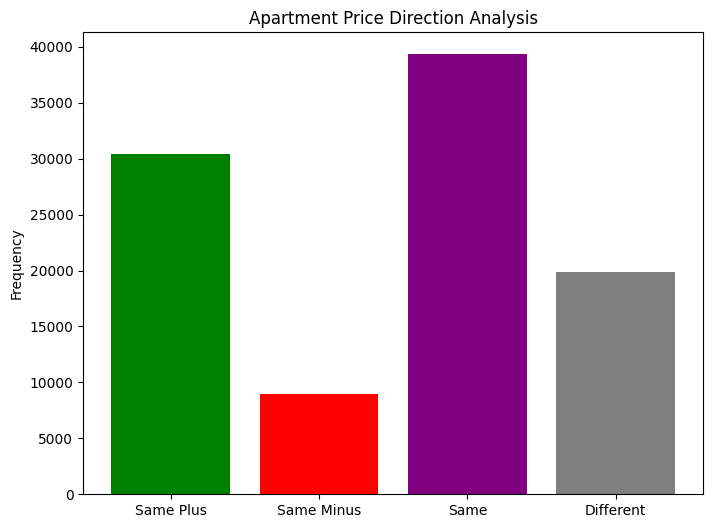

일치율: 0.6647399820852136


In [75]:
import matplotlib.pyplot as plt

# 데이터 준비
categories = ['Same Plus', 'Same Minus', 'Same', 'Different']
values = [n_correct_plus, n_correct_minus, n_correct_plus + n_correct_minus, n_wrong]

# 막대 그래프 생성
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['green', 'red', 'purple', 'grey'])
plt.ylabel('Frequency')
plt.title('Apartment Price Direction Analysis')
plt.show()

print(f'일치율: {(n_correct_plus + n_correct_minus) / (n_wrong + n_correct_plus + n_correct_minus)}')

## (참고) Q: 무작위로 두 아파트를 선택하여 가격 변화의 방향을 비교하면 어떨까?

In [76]:
id_to_area_ids = {}
for loc_id, group in house_df.groupby('loc_id'):
    id_to_area_ids[loc_id] = group['loc_area_id'].unique()

n_correct_plus = 0
n_correct_minus = 0
n_wrong = 0

# 20년부터 22년까지, 반년 간격으로 측정합니다.
start_datetime = pd.Timestamp('2020-01-01')
end_datetime = pd.Timestamp('2022-01-01')
cur_datetime = start_datetime
delta = pd.Timedelta(days=180)
while cur_datetime < end_datetime + delta:
    next_datetime = cur_datetime + delta

    for _ in range(1000):
        # 랜덤한 두 아파트의 가격 변화를 계산합니다.
        area_ids = list(area_id_to_deposit_series.keys())
        chosen_area_ids = np.random.choice(area_ids, size=2, replace=False)
        deposit_series1 = area_id_to_deposit_series[chosen_area_ids[0]]
        deposit_series2 = area_id_to_deposit_series[chosen_area_ids[1]]

        cur_deposit = deposit_series1.loc[cur_datetime]
        next_deposit = deposit_series1.loc[next_datetime]
        deposit_diff1 = next_deposit - cur_deposit

        cur_deposit = deposit_series2.loc[cur_datetime]
        next_deposit = deposit_series2.loc[next_datetime]
        deposit_diff2 = next_deposit - cur_deposit


        if (np.isnan(deposit_diff1) or np.isnan(deposit_diff2) or
            deposit_diff1 == 0 or deposit_diff2 == 0):
            continue

        # 두 집의 변화 추세가 같은지 다른지를 셉니다.
        if np.sign(deposit_diff1) == np.sign(deposit_diff2) == 1:
            n_correct_plus += 1
        elif np.sign(deposit_diff1) == np.sign(deposit_diff2) == -1:
            n_correct_minus += 1
        else:
            n_wrong += 1

    cur_datetime = next_datetime

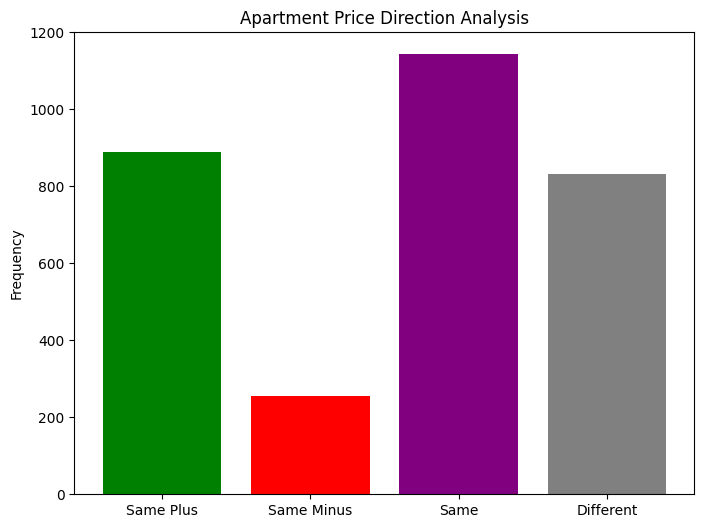

일치율: 0.5790273556231003


In [77]:
import matplotlib.pyplot as plt

# 데이터 준비
categories = ['Same Plus', 'Same Minus', 'Same', 'Different']
values = [n_correct_plus, n_correct_minus, n_correct_plus + n_correct_minus, n_wrong]

# 막대 그래프 생성
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['green', 'red', 'purple', 'grey'])
plt.ylabel('Frequency')
plt.title('Apartment Price Direction Analysis')
plt.show()

print(f'일치율: {(n_correct_plus + n_correct_minus) / (n_wrong + n_correct_plus + n_correct_minus)}')